In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:97% !important; }</style>"))

import jupyternotify
ip = get_ipython()
ip.register_magics(jupyternotify.JupyterNotifyMagics)

import scoring as score # para hacer los reportes de puntajes
from time import time

from sklearn import preprocessing
from sklearn.linear_model import Perceptron
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, RandomizedSearchCV, ShuffleSplit, train_test_split

properati = pd.read_csv('datos/caba_para_mapa.csv',error_bad_lines=False)

#tenia un nan nose porque
properati.dropna(inplace=True)

<IPython.core.display.Javascript object>

## Preparo las columnas a usar

In [23]:
cant_buckets = 500

#buckets
cantidad,rango = np.histogram(properati['price_usd_per_m2'], bins=cant_buckets)
properati['categories_by_price']=pd.cut(properati['price_usd_per_m2'],rango,labels=np.arange(cant_buckets))
properati['price_range']=pd.cut(properati['price_usd_per_m2'],rango)
#lo casteo a float porque si no tira error 
properati['categories_by_price']=properati['categories_by_price'].astype(np.float64) 

#tenia un nan nose porque
properati.dropna(inplace=True)


In [24]:
#Creo un scoring nuevo
from sklearn.metrics import precision_score,make_scorer
precision = make_scorer(precision_score,average="macro")

### Busco una aproximacion de hiper-parametros con random search

In [5]:
%%notify

#preparo set de datos
X = zip(properati['dist_a_subte'],properati['dist_a_univ'],properati['dist_a_tren'],properati['dist_a_villa'],\
        properati['dist_a_zona_anegada'],properati['surface_total_in_m2'],\
        properati['surface_covered_in_m2'],properati['lat'],properati['lon'])
y = properati['categories_by_price']

from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler = StandardScaler()
scaler2= MinMaxScaler()

X=scaler.fit_transform(X,y)
X=scaler2.fit_transform(X,y)

perceptron = Perceptron(n_jobs=-1)

scoring={"accuracy":"accuracy"} # defino diccionario para varios scorings

# Utility function to report best scores
alpha=np.arange(0.000001,1,0.000001)
pen =['l2','l1','elasticnet']
param_grid = {"alpha": alpha, "penalty": pen}

custom_cv = ShuffleSplit(n_splits=5, test_size=0.2)

# run randomized search
random_search = RandomizedSearchCV(perceptron, param_distributions=param_grid,
n_iter=100,cv=custom_cv,scoring=scoring,refit=False) #refit=False es para poder usar multiscoring
start = time()
random_search.fit(X, y)

print("RandomizedSearchCV duro %.2f segundos para %d candidatos a hiper-parametros."
    % (time() - start, len(random_search.cv_results_['params'])))
print("")
score.report_multi(random_search.cv_results_,scoring.keys())

RandomizedSearchCV duro 145.30 segundos para 100 candidatos a hiper-parametros.

Puntajes usando accuracy
Puesto: 1
Promedio training score: 0.007 (std: 0.005)
Promedio validation score: 0.005 (std: 0.005)
Hiper-parametros: {'penalty': 'elasticnet', 'alpha': 0.75057200000000002}

Puesto: 1
Promedio training score: 0.007 (std: 0.005)
Promedio validation score: 0.005 (std: 0.005)
Hiper-parametros: {'penalty': 'l2', 'alpha': 0.007156}

Puesto: 1
Promedio training score: 0.007 (std: 0.005)
Promedio validation score: 0.005 (std: 0.005)
Hiper-parametros: {'penalty': 'elasticnet', 'alpha': 0.96223599999999998}

Puesto: 1
Promedio training score: 0.007 (std: 0.005)
Promedio validation score: 0.005 (std: 0.005)
Hiper-parametros: {'penalty': 'l2', 'alpha': 0.36449899999999996}

Puesto: 1
Promedio training score: 0.007 (std: 0.005)
Promedio validation score: 0.005 (std: 0.005)
Hiper-parametros: {'penalty': 'l2', 'alpha': 0.87798999999999994}

Puesto: 1
Promedio training score: 0.007 (std: 0.005)


<IPython.core.display.Javascript object>

### Busco mas detalladamente los hiper-parametros en el rango de los mejores resultados con Grid Search

In [53]:
%%notify

#preparo set de datos
X = zip(properati['dist_a_subte'],properati['dist_a_univ'])
y = properati['categories_by_price']

perceptron = Perceptron(n_jobs=-1)
        
alpha=np.arange(0.2,0.5,0.01)
pen =['l2','elasticnet']
param_grid = {"alpha": alpha, "penalty": pen}

custom_cv = ShuffleSplit(n_splits=5, test_size=0.2)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2)

grid_search = GridSearchCV(perceptron,param_grid=param_grid,cv=custom_cv)
start = time()
grid_search.fit(X_train, y_train)

print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
    % (time() - start, len(grid_search.cv_results_['params'])))
score.report_single(grid_search.cv_results_)

GridSearchCV took 71.46 seconds for 60 candidate parameter settings.
Puesto: 1
Promedio training score: 0.006 (std: 0.003)
Promedio validation score: 0.007 (std: 0.003)
Promedio fit time: 0.214s
Hiper-parametros: {'penalty': 'l2', 'alpha': 0.24000000000000005}

Puesto: 1
Promedio training score: 0.006 (std: 0.003)
Promedio validation score: 0.007 (std: 0.003)
Promedio fit time: 0.219s
Hiper-parametros: {'penalty': 'elasticnet', 'alpha': 0.24000000000000005}

Puesto: 1
Promedio training score: 0.006 (std: 0.003)
Promedio validation score: 0.007 (std: 0.003)
Promedio fit time: 0.222s
Hiper-parametros: {'penalty': 'l2', 'alpha': 0.25000000000000006}

Puesto: 1
Promedio training score: 0.006 (std: 0.003)
Promedio validation score: 0.007 (std: 0.003)
Promedio fit time: 0.245s
Hiper-parametros: {'penalty': 'elasticnet', 'alpha': 0.25000000000000006}

Puesto: 1
Promedio training score: 0.006 (std: 0.003)
Promedio validation score: 0.007 (std: 0.003)
Promedio fit time: 0.232s
Hiper-parametros:

<IPython.core.display.Javascript object>

In [54]:
mejor_rf = grid_search.best_estimator_
print mejor_rf

Perceptron(alpha=0.24000000000000005, class_weight=None, eta0=1.0,
      fit_intercept=True, max_iter=5, n_iter=None, n_jobs=-1, penalty='l2',
      random_state=0, shuffle=True, tol=None, verbose=0, warm_start=False)


In [55]:
errores = mejor_rf.predict(X_test)-y_test
print ("Error maximo:{0}\nError minimo:{1}".format( max(abs(errores)),min(abs(errores))))
print(errores)

Error maximo:268.0
Error minimo:0.0
26403    131.0
3927       0.0
7642      -4.0
21900     74.0
27299     35.0
32042     80.0
4497     105.0
13209     83.0
33361    -52.0
27290    152.0
33751    114.0
12958    112.0
6322     111.0
28102    -22.0
31498      0.0
1258     144.0
27357    107.0
40909     76.0
13226      0.0
29516     27.0
8550      67.0
43898    102.0
11       160.0
1293     112.0
9002      84.0
7584      50.0
29488    112.0
7537     106.0
31429    -28.0
12674    116.0
         ...  
3545      53.0
7808     113.0
8775     112.0
39072     82.0
29502     69.0
7378      50.0
7810     113.0
38646    119.0
1283     118.0
4216     127.0
3158      79.0
7012     104.0
9170      11.0
14939    -73.0
8814     143.0
7527      96.0
41757     69.0
9453     122.0
36928     81.0
33671     16.0
10232     48.0
26507     87.0
6575     109.0
26168    123.0
29245     88.0
8230     106.0
17712    110.0
10751     86.0
26373     99.0
33622     99.0
Name: categories_by_price, Length: 492, dtype: fl

In [57]:
count_max=0
max_error=100
lista=[]
for error in errores:
    if abs(error)>max_error:
        count_max+=1
        lista.append(abs(error))
count_max

199

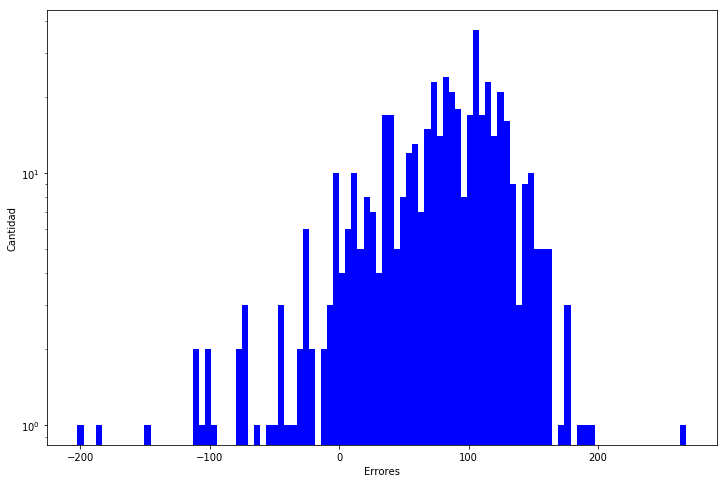

In [58]:
# the histogram of the data
plt.figure(figsize=(12,8))
plt.hist(errores, 100, facecolor='blue')
plt.xlabel('Errores')
plt.ylabel('Cantidad')
#plt.xlim(-1000, 1000) #para variar el "zoom a 0"
plt.yscale('log')
plt.show()